## EE 461P: Data Science Principles  
### Term Project
### Blog Due: May 13, 2021 
### Presentation May 4, 2021





In [1]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
import os, sys, re
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import plot_roc_curve 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import r2_score
from sklearn.naive_bayes import BernoulliNB

#Load dataset from csv file
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
print("data loaded")

data loaded


In [2]:
#Data preprocessing 
df = pd.get_dummies(df, prefix_sep="_", columns=['type'])
for col in ["nameOrig","nameDest"]:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes
df["unequalChangeAccounts"] = np.where((df["oldbalanceOrg"]-df["newbalanceOrig"])!=(df["newbalanceDest"]-df["oldbalanceDest"]),1,0)
df["flowDirection"] = np.where((df["oldbalanceOrg"]-df["newbalanceOrig"])<(df["oldbalanceDest"]-df["newbalanceDest"]),1,0)
df["unequalChangeAmount1"] = np.where((df["amount"])!=abs(df["newbalanceOrig"]-df["oldbalanceOrg"]),1,0)
df["unequalChangeAmount2"] = np.where((df["amount"])!=abs(df["newbalanceDest"]-df["oldbalanceDest"]),1,0)
df = df.drop(["oldbalanceOrg","newbalanceOrig","newbalanceDest","oldbalanceDest","amount","isFlaggedFraud","step"],axis=1)
fraud_rows = df[df['isFraud']==1].copy()
not_fraud_rows = df[df['isFraud']==0].copy()
X=df
y = df.pop("isFraud")
X_tr, X_te, y_tr, y_te = train_test_split(X,y, test_size=0.25, random_state = 42)
f_y = fraud_rows.pop("isFraud")
f_x = fraud_rows
nf_y = not_fraud_rows.pop("isFraud")
nf_x = not_fraud_rows
print("data processed")

data processed


In [67]:
bnb = BernoulliNB(fit_prior=False)
bnb.fit(X_tr,y_tr)
print("Model Accuracy on All Test Data: {}".format(bnb.score(X_te,y_te)))
print("Model Accuracy for predicting true fraud: {}".format(bnb.score(f_x,f_y)))
print("Model Accuracy for predicting true not fraud: {}".format(bnb.score(nf_x,nf_y)))
print(roc_auc_score(y_te,bnb.predict_proba(X_te)[:,1]))

Model Accuracy on All Test Data: 0.9774998349736429
Model Accuracy for predicting true fraud: 0.9902593449409473
Model Accuracy for predicting true not fraud: 0.9773210938487258
0.9928036685790221


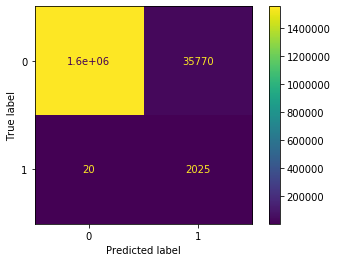

In [68]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(bnb, X_te, y_te)

3.3) AUCROC: 0.9928104087981208 Alpha: 0.018824679033962337


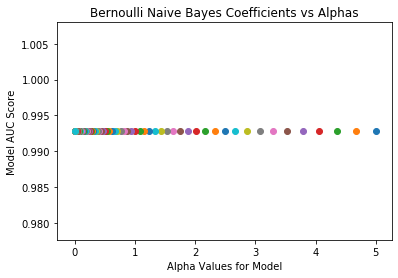

In [10]:
from sklearn.metrics import r2_score
from sklearn import linear_model
fig = plt.figure()
alphas=10**np.linspace(1,-2,100)*0.5
best_alpha = 0
best_auc = 0
best_model = None
model_coefficients = []
for my_alpha in alphas:
    bnb = BernoulliNB(alpha=my_alpha, fit_prior=False)
    my_fit = bnb.fit(X_tr, y_tr)
    auc = roc_auc_score(y_te,bnb.predict_proba(X_te)[:,1])
    model_coefficients.append(auc)
    if (auc > best_auc):
        best_auc = auc
        best_alpha = my_alpha
        best_model = bnb
print("3.3) AUCROC: "+str(best_auc)+" Alpha: "+str(best_alpha))
plt.xlabel("Alpha Values for Model")
plt.ylabel("Model AUC Score")
plt.title("Bernoulli Naive Bayes Coefficients vs Alphas")
for alpha, coef in zip(alphas, model_coefficients):
    plt.scatter([alpha], coef)

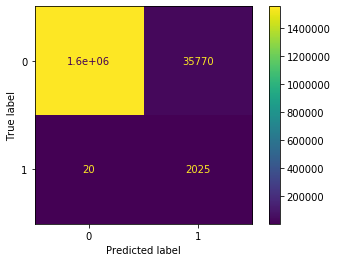

In [9]:
plot_confusion_matrix(best_model, X_te, y_te)

In [32]:
print(df.columns)

Index(['nameOrig', 'nameDest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER', 'unequalChangeAccounts',
       'flowDirection', 'unequalChangeAmount1', 'unequalChangeAmount2'],
      dtype='object')


[[2.13778467e-07 1.05309296e-06 1.51346445e+00 1.04518426e+00
  5.03233324e+00 1.08326979e+00 2.48630946e+00 1.73965653e-01
  1.50776952e+00 1.56607783e-01 1.61712640e-01]
 [3.05197679e-06 3.05197679e-06 1.26997226e+01 6.90233160e-01
  1.26997226e+01 1.26997226e+01 6.96069717e-01 3.05568916e-01
  6.42267023e+00 4.79494134e+00 3.05348871e-01]]


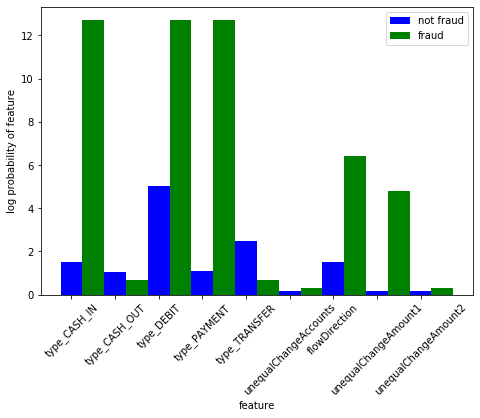

In [64]:
#df.drop("nameOrig", inplace=True, axis=1)
#df.drop("nameDest", inplace=True, axis=1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
feature_prob = abs(best_model.feature_log_prob_)
print(feature_prob)
br1 = np.arange(len(df.columns))
br2 = [x + 0.5 for x in br1]
ax.bar(br1, feature_prob[0][2:], color = 'b', width = 0.5, label="not fraud")
ax.bar(br2, feature_prob[1][2:], color = 'g', width = 0.5, label="fraud")
plt.xticks(range(len(df.columns)))
ax.set_xticklabels(df.columns, rotation = 45)
ax.set_ylabel("log probability of feature")
ax.set_xlabel("feature")
ax.legend()
